# Can You Predict SSIM from PSNR? Let’s Find Out

The Peak Signal-to-Noise Ratio (PSNR) is a simple metric. It measures the average squared error between two images and turns it into a logarithmic scale. It's fast, cheap and easy to compute

The Structural Similarity Index Measure (SSIM), on the other hand, is more perceptually motivated. It looks at local structure, contrast, and luminance. It operates window by window. It feels more sophisticated and refined.

Because of this, PSNR and SSIM are often treated as fundamentally different metrics.

But are they?
- What if PSNR actually contains more structural information than we usually assume?
- What if SSIM can be predicted, or at least _approxSSIMated_, from PSNR and statistics of the reference image?

In this notebook, we will:
- Revisit the mathematical definitions of PSNR and SSIM
- Visualize how they behave on compression-based distortions
- Walk through the key assumptions behind their relationship
- Translate those assumptions directly into code.

This is not a formal paper (I already wrote one of those), this is a guided exploration.

Let's start with the basics.

# A Tale of Two Qualities

We begin with a single reference image. In this notebook, we will use kodim23 from the Kodak image dataset.

Now we compress it twice:
- Once at JPEG quality 50
- Once at JPEG quality 25

If you look closesly, you can start to see the differences.

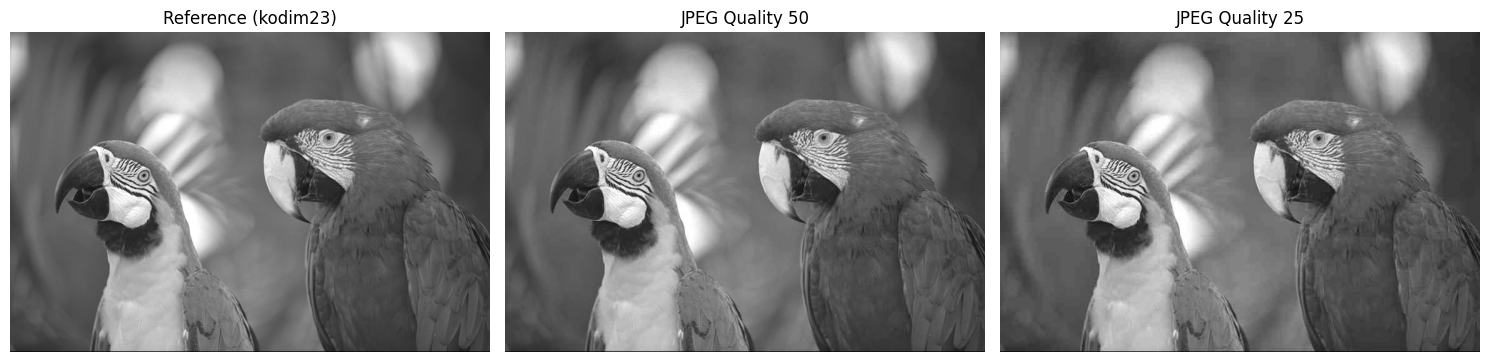

In [40]:
import io
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
from scipy.ndimage import uniform_filter
from skimage.metrics import structural_similarity as ssim_ref
from skimage.util import crop
import urllib.request

def fetch_kodak(index=23, cache_dir="data"):
    """
    Download a Kodak image (1-24) if not already cached.
    Returns a numpy array (grayscale).
    """
    assert 1 <= index <= 24, "Kodak index must be between 1 and 24"
    
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    filename = f"kodim{index:02d}.png"
    filepath = cache_dir / filename
    
    if not filepath.exists():
        url = f"http://r0k.us/graphics/kodak/kodak/{filename}"
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    
    img = Image.open(filepath).convert("L")
    return np.array(img, dtype=np.uint8)

def jpeg_compress(img, quality=75):
    buffer = io.BytesIO()
    Image.fromarray(img, 'L').save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

ref = fetch_kodak(23)
q25 = np.array(jpeg_compress(ref, quality=25), dtype=np.uint8)
q50 = np.array(jpeg_compress(ref, quality=50), dtype=np.uint8)

def show_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ref, cmap="gray")
    axes[0].set_title("Reference (kodim23)")
    axes[0].axis("off")

    axes[1].imshow(q50, cmap="gray")
    axes[1].set_title("JPEG Quality 50")
    axes[1].axis("off")

    axes[2].imshow(q25, cmap="gray")
    axes[2].set_title("JPEG Quality 25")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
show_images()

But here is something important for later: _these images are not random or unrelated. They are two compressed versions of the same underlying signal. There is structure connecting them._

We will come back to that idea. For now, let’s ask a simpler question:

_How can we measure the “distance” between these images?_

There are many ways to measure error: absolute error, squared error, perceptual metrics... but in compression, one metric dominates: the Mean Squared Error (MSE).

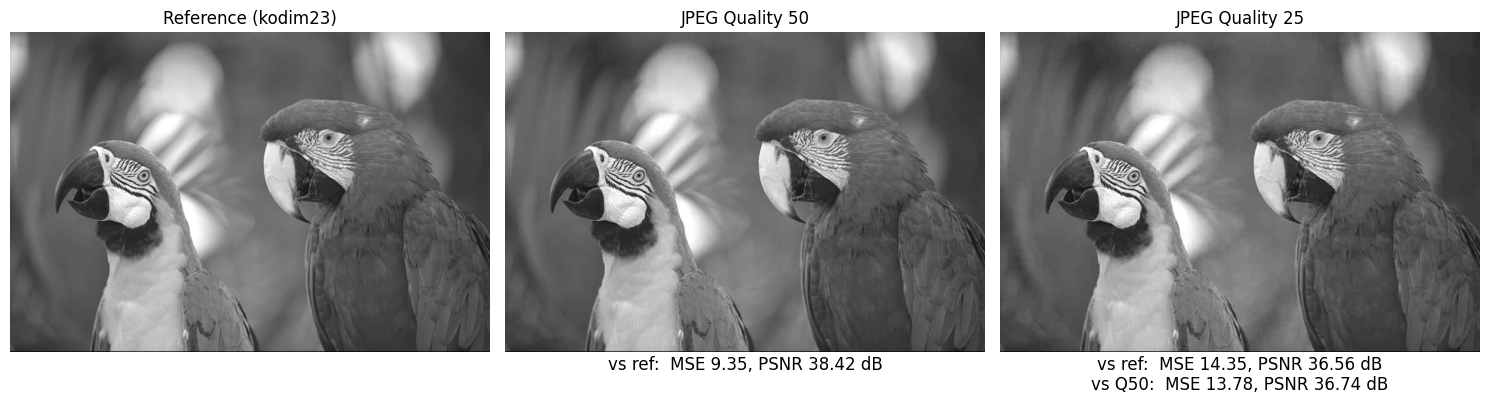

In [41]:
def mse(a, b):
    return np.mean(np.square(a - b))

def psnr(a, b, data_range=255.0):
    mse_val = mse(a, b)
    if mse_val == 0:
        return float('inf')
    return 10 * np.log10(np.square(data_range) / mse_val)

mse_q50 = mse(ref, q50)
mse_q25 = mse(ref, q25)
psnr_q50 = psnr(ref, q50)
psnr_q25 = psnr(ref, q25)
mse_50_25 = mse(q50, q25)
psnr_50_25 = psnr(q50, q25)

def show_images_with_metrics():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(ref, cmap="gray")
    axes[0].set_title("Reference (kodim23)")
    axes[0].axis("off")

    axes[1].imshow(q50, cmap="gray")
    axes[1].set_title("JPEG Quality 50")
    axes[1].axis("off")
    axes[1].text(0.5, -0.01,
        f"vs ref:  MSE {mse_q50:.2f}, PSNR {psnr_q50:.2f} dB",
        transform=axes[1].transAxes, ha="center", va="top", fontsize=12)

    axes[2].imshow(q25, cmap="gray")
    axes[2].set_title("JPEG Quality 25")
    axes[2].axis("off")
    axes[2].text(
        0.5, -0.01,
        f"vs ref:  MSE {mse_q25:.2f}, PSNR {psnr_q25:.2f} dB\n"
        f"vs Q50:  MSE {mse_50_25:.2f}, PSNR {psnr_50_25:.2f} dB",
        transform=axes[2].transAxes,
        ha="center",
        va="top",
        fontsize=12)
    
    plt.subplots_adjust(bottom=0.25)
    plt.tight_layout()
    plt.show()
show_images_with_metrics()

## Measuring Distance Isn’t the Same as Measuring Quality

We now have numbers!
 - Q50 is closer to the reference than Q25.
 - The MSE between Q50 and Q25 is non-zero.
 - PSNR converts those errors into decibels.

So far, everything makes sense. But notice something subtle.

MSE treats every pixel independently. It doesn’t know anything about:
 - Edges
 - Texture
 - Contrast
 - Spatial structure

It just squares differences and averages them. That means two images with very different visual distortions can produce similar MSE values.

MSE answers the question: _How far apart are these images numerically?_

But compression engineers usually care about something slightly different: _How different do they look?_

That’s where SSIM enters the story.

# Enter SSIM: Structure Matters

Now let’s compute SSIM between the images.

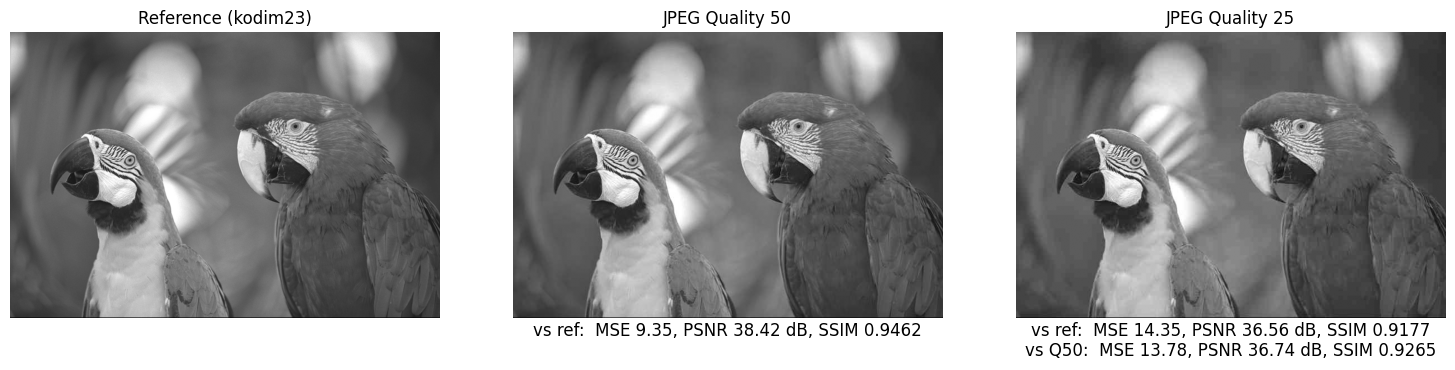

In [48]:
def ssim(im1, im2, win_size=7, data_range=255, K1=0.01, K2=0.03):
    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    im1 = im1.astype(np.float64, copy=False)
    im2 = im2.astype(np.float64, copy=False)

    NP = win_size * win_size
    cov_norm = NP / (NP - 1)

    # Local means
    ux = uniform_filter(im1, size=win_size)
    uy = uniform_filter(im2, size=win_size)

    # Local second moments
    uxx = uniform_filter(im1 * im1, size=win_size)
    uyy = uniform_filter(im2 * im2, size=win_size)
    uxy = uniform_filter(im1 * im2, size=win_size)
    
    # Local variances and covariance
    vx = np.maximum(cov_norm * (uxx - ux * ux), 0.0)
    vy = np.maximum(cov_norm * (uyy - uy * uy), 0.0)
    vxy = cov_norm * (uxy - ux * uy)

    # SSIM formula
    A1 = 2 * ux * uy + C1
    A2 = 2 * vxy + C2   
    B1 = ux**2 + uy**2 + C1
    B2 = vx + vy + C2

    # Local SSIM
    S = (A1 * A2) / (B1 * B2)

    pad = (win_size - 1) // 2
    # Global SSIM (excluding borders)
    return crop(S, pad).mean(dtype=np.float64)

ssim_q50 = ssim(ref, q50)
ssim_q25 = ssim(ref, q25)
ssim_50_25 = ssim(q50, q25)

# Check that our implementation matches skimage's reference implementation
assert(np.isclose(ssim_q50, ssim_ref(ref, q50, data_range=255)))
assert(np.isclose(ssim_q25, ssim_ref(ref, q25, data_range=255)))
assert(np.isclose(ssim_50_25, ssim_ref(q50, q25, data_range=255)))

def show_images_with_ssim():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(ref, cmap="gray")
    axes[0].set_title("Reference (kodim23)")
    axes[0].axis("off")

    axes[1].imshow(q50, cmap="gray")
    axes[1].set_title("JPEG Quality 50")
    axes[1].axis("off")
    axes[1].text(0.5, -0.01,
        f"vs ref:  MSE {mse_q50:.2f}, PSNR {psnr_q50:.2f} dB, SSIM {ssim_q50:.4f}",
        transform=axes[1].transAxes, ha="center", va="top", fontsize=12)

    axes[2].imshow(q25, cmap="gray")
    axes[2].set_title("JPEG Quality 25")
    axes[2].axis("off")
    axes[2].text(
        0.5, -0.01,
        f"vs ref:  MSE {mse_q25:.2f}, PSNR {psnr_q25:.2f} dB, SSIM {ssim_q25:.4f}\n"
        f"vs Q50:  MSE {mse_50_25:.2f}, PSNR {psnr_50_25:.2f} dB, SSIM {ssim_50_25:.4f}",
        transform=axes[2].transAxes,
        ha="center",
        va="top",
        fontsize=12)
    
    plt.subplots_adjust(bottom=0.25)
    plt.tight_layout()
    plt.show()
show_images_with_ssim()


Unlike MSE or PSNR, SSIM does not treat an image as just a long list of pixels.
Instead, it compares images locally, window by window.

Inside each window, it measures:
 - The local mean (luminance)
 - The local variance (contrast)
 - The local covariance (structure similarity)

In other words, SSIM asks:_Do these two images have similar brightness, contrast, and structure?_

That’s why the implementation above:
 - Computes local averages using a sliding window
 - Estimates local variances and covariance
 - Combines them into the SSIM formula
 - Averages the result over the entire image

The result is a score between between 0 and 1, where 1 means identical.

# When Errors Follow Rules

As we mentioned earlier, we are not comparing unrelated images to one another. We are comparing an image to compressed versions of itself.

Not only do these images share the same underlying structure, but the errors themselves are structured. That structure arises because JPEG does not introduce arbitrary noise. It introduces quantization error in the DCT domain.

The distortion is therefore tied to the image content and to the transform used during compression. It is not random; it follows rules. And once distortions follow rules, they become predictable.

## Assumption 1: Local Means Are Approximately Equal

In her paper [Measuring Objective Image and Video Quality: On the Relationship Between SSIM and PSNR for DCT-Based Compressed Images](https://www.techrxiv.org/doi/full/10.36227/techrxiv.21725390.v1), Maria Martini found that when an image is compressed using a transform codec like JPEG, the local averages tend to be preserved.

This means that `ux == uy`

### Why would this be true?

Because JPEG treats low-frequency information very carefully.

In an 8×8 DCT block:
 - The DC coefficient represents the average intensity of the block.
 - JPEG encodes DC coefficients separately.
 - They are differentially coded and typically quantized much more gently than high-frequency coefficients.

In other words: _JPEG goes out of its way to preserve the block average._

And since SSIM computes local means using sliding windows, those windows are strongly influenced by preserved DC content.

So under JPEG compression, it is reasonable to assume: _The local means of the original and compressed images are approximately equal._

This is not universally true for arbitrary distortions, but for transform-based compression, it is often a very good approximation.

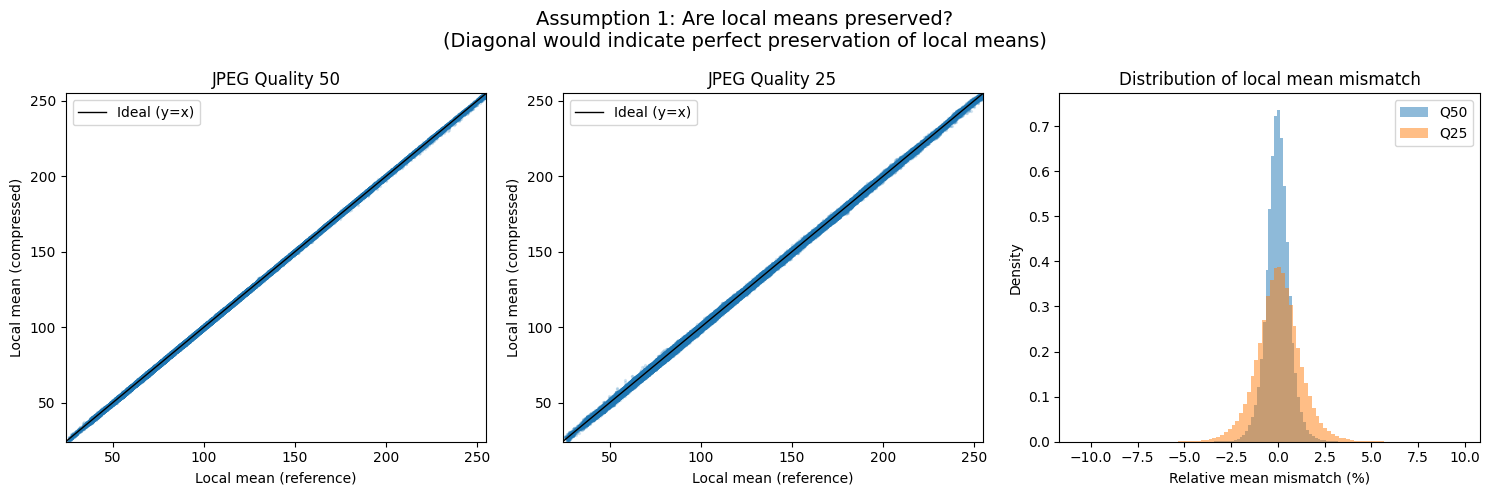

In [101]:
def local_mean(im, win_size=7):
    im = im.astype(np.float64, copy=False)
    return uniform_filter(im, size=win_size)

ux = local_mean(ref)
uy50 = local_mean(q50)
uy25 = local_mean(q25)

eps = 1e-8
rel_diff_q50 = (ux - uy50) / np.maximum((ux + eps), 1.0) * 100
rel_diff_q25 = (ux - uy25) / np.maximum((ux + eps), 1.0) * 100

def plot_local_mean_comparison():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Assumption 1: Are local means preserved?\n(Diagonal would indicate perfect preservation of local means)", fontsize=14)

    axes[0].scatter(x=ux.flatten(), y=uy50.flatten(), s=2, marker="x", alpha=0.2)
    axes[0].set_title("JPEG Quality 50")

    axes[1].scatter(x=ux.flatten(), y=uy25.flatten(), s=2, marker="x", alpha=0.2)
    axes[1].set_title("JPEG Quality 25")

    mn = min(ux.min(), uy50.min(), uy25.min())
    mx = max(ux.max(), uy50.max(), uy25.max())
    for ax in axes[:2]:
        ax.plot([mn, mx], [mn, mx], linewidth=1, color="black", label="Ideal (y=x)")
        ax.set_xlim(mn, mx)
        ax.set_ylim(mn, mx)
        ax.set_xlabel("Local mean (reference)")
        ax.set_ylabel("Local mean (compressed)")
        ax.legend()

    axes[2].hist(rel_diff_q50.flatten(), bins=100, alpha=0.5, label="Q50", density=True)
    axes[2].hist(rel_diff_q25.flatten(), bins=100, alpha=0.5, label="Q25", density=True)

    axes[2].set_xlabel("Relative mean mismatch (%)")
    axes[2].set_ylabel("Density")
    axes[2].set_title("Distribution of local mean mismatch")
    axes[2].legend()

    plt.tight_layout()
    plt.show()
plot_local_mean_comparison()

### What Do We See?

In the first two plots, the diagonal line represents perfect preservation of local means (`ux == uy`). For both Q50 and Q25, nearly all points lie very close to that diagonal. Even under stronger compression (Q25), the local averages remain tightly aligned with the reference.

The histogram on the right confirms this: _most local mean differences are centered near zero and remain small in magnitude_.

In other words:
 - JPEG compression barely shifts local luminance.
 - This directly supports the first assumption in Maria Martini’s paper.

If local means are preserved, part of the SSIM formula simplifies.

Now the real question becomes: _Are local variances preserved as well?_

Let’s test that next.

## Assumption 2 — Are Local Variances Preserved?

In her paper [Measuring Objective Image and Video Quality: On the Relationship Between SSIM and PSNR for DCT-Based Compressed Images](https://www.techrxiv.org/doi/full/10.36227/techrxiv.21725390.v1), Maria Martini found that when an image is compressed using a transform codec like JPEG, the local variances tend to be preserved.

This means that `vx == vy`

Why might this be reasonable?

Because JPEG does not randomly scramble contrast.

It:
 - Quantizes DCT coefficients,
 - Preserves low-frequency energy relatively well,
 - And introduces distortion proportional to signal activity.

That means texture and contrast are degraded, but not completely reshaped.

The question is: How close are they really?


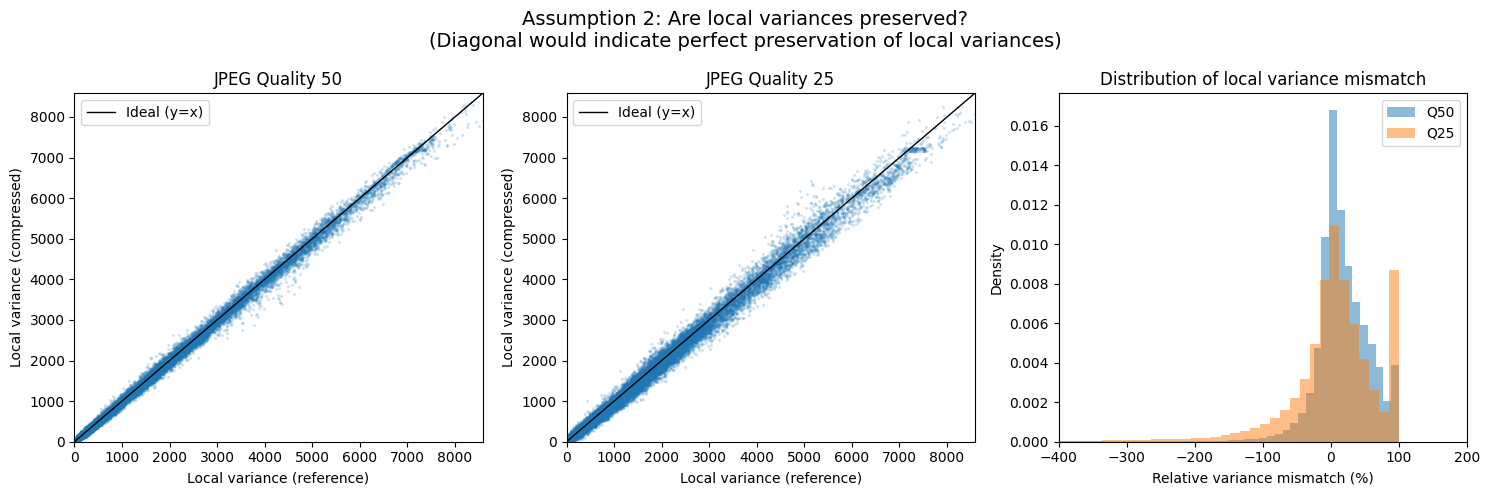

In [115]:
def local_var(im, win_size=7):
    im = im.astype(np.float64, copy=False)
    u = uniform_filter(im, size=win_size)
    uu = uniform_filter(im * im, size=win_size)
    NP = win_size * win_size
    cov_norm = NP / (NP - 1)
    return np.maximum(cov_norm * (uu - u * u), 0.0)

vx = local_var(ref)
vy50 = local_var(q50)
vy25 = local_var(q25)

eps = 1e-8
rel_diff_q50 = ((vx - vy50) / np.maximum((vx + eps), 1.0)) * 100
rel_diff_q25 = ((vx - vy25) / np.maximum((vx + eps), 1.0)) * 100

def plot_local_var_comparison():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Assumption 2: Are local variances preserved?\n(Diagonal would indicate perfect preservation of local variances)", fontsize=14)

    axes[0].scatter(x=vx.flatten(), y=vy50.flatten(), s=2, marker="x", alpha=0.2)
    axes[0].set_title("JPEG Quality 50")

    axes[1].scatter(x=vx.flatten(), y=vy25.flatten(), s=2, marker="x", alpha=0.2)
    axes[1].set_title("JPEG Quality 25")

    mn = min(vx.min(), vy50.min(), vy25.min())
    mx = max(vx.max(), vy50.max(), vy25.max())
    for ax in axes[:2]:
        ax.plot([mn, mx], [mn, mx], linewidth=1, color="black", label="Ideal (y=x)")
        ax.set_xlim(mn, mx)
        ax.set_ylim(mn, mx)
        ax.set_xlabel("Local variance (reference)")
        ax.set_ylabel("Local variance (compressed)")
        ax.legend()

    axes[2].hist(rel_diff_q50.flatten(), bins=300, alpha=0.5, label="Q50", density=True)
    axes[2].hist(rel_diff_q25.flatten(), bins=300, alpha=0.5, label="Q25", density=True)
    axes[2].set_xlim(-400, 200)

    axes[2].set_xlabel("Relative variance mismatch (%)")
    axes[2].set_ylabel("Density")
    axes[2].set_title("Distribution of local variance mismatch")
    axes[2].legend()

    plt.tight_layout()
    plt.show()
plot_local_var_comparison()

### What Do These Plots Tell Us?

Just like with local means, the scatter plots show that most points lie close to the diagonal. This means local variances in the compressed images remain close to those of the reference image (even at lower quality). The lower the quality (Q25), the wider the spread, but the structure is still strongly aligned.

The histogram confirms this: _Most local variance mismatches cluster near zero_.

Notice something important: _The points are distributed on both sides of the diagonal_.

Some blocks have slightly higher variance after compression. Some have slightly lower variance. But when we average over many windows, these deviations partially cancel out.

In other words: _Small local errors wash out when aggregated globally_.

And that is exactly why the assumption `vx = vy` can hold surprisingly well in practice.